In [1]:
import json
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
with open('siparis.json',encoding="utf8") as f:
    data = json.load(f)


In [3]:
df = pd.DataFrame(data,columns = ['Comment','Brand','Sector'])
len(df)

98342

In [4]:
filter = df["Comment"] != ""


In [5]:
filter.value_counts()

True    98342
Name: Comment, dtype: int64

In [6]:
df = df[filter]
len(df)

98342

In [7]:
df = df.dropna() 
len(df)

98342

# Konu Basliklari

In [8]:
#print(df.Brand.value_counts())
#a = df.Brand.value_counts()

In [9]:
df["Sector"] = df.Brand.map(lambda sentences: None )

In [10]:
taşıma_list = ["Aras Kargo","Sürat Kargo","MNG Kargo","Horoz Lojistik","Trendyol Express","UPS Türkiye","hepsiJET","Getir"]
for i in taşıma_list:
    df.Sector[df.Brand == i ] = "Taşıma"

In [11]:
giyim_list = ["Penti","Boyner","DeFacto","Gratis", "LC Waikiki","FLO Ayakkabı","Bershka"]
for i in giyim_list:
    df.Sector[df.Brand == i ] = "Giyim"

In [12]:
yemek_list = ["Yemek Sepeti","Domino's Pizza","Protein Market"]
for i in yemek_list:
    df.Sector[df.Brand == i ] = "Yemek"

In [13]:
teknoloji_list = ["Media Markt"]
for i in teknoloji_list:
    df.Sector[df.Brand == i ] = "Teknoloji"

In [14]:
ev_esyasi_list = ["Evform","Tekzen","IKEA"]
for i in ev_esyasi_list:
    df.Sector[df.Brand == i ] = "EvEsyasi"

In [15]:
kitap_list = ["Kitap Seç","Bkm Kitap","D&R"]
for i in kitap_list:
    df.Sector[df.Brand == i ] = "Kitap"

In [16]:
ticaret_sitesi_list = ["Çiçek Sepeti","N11"]
for i in ticaret_sitesi_list:
    df.Sector[df.Brand == i ] = "ETicaret"

In [17]:
filter = df["Sector"] != ""
filter.value_counts()

True    98342
Name: Sector, dtype: int64

In [18]:
df = df[filter]
len(df)

98342

In [19]:
df1 = df.dropna()
df1.Sector.value_counts()

Taşıma       22101
Giyim        14658
ETicaret      7583
Yemek         2477
Kitap         2475
EvEsyasi      2297
Teknoloji      646
Name: Sector, dtype: int64

# Alt Konu Basliklari

In [20]:
konu_list = ["Giyim","Taşıma","Yemek","Teknoloji","Ev Eşyası","Kitap"]
data_kitap = df1.Comment[df.Sector == "Kitap"]
data_giyim = df1.Comment[df.Sector == "Giyim"]
data_tasıma = df1.Comment[df.Sector == "Taşıma"]
data_yemek = df1.Comment[df.Sector == "Yemek"]
data_teknoloji = df1.Comment[df.Sector == "Teknoloji"]
data_esya = df1.Comment[df.Sector == "EvEsyasi"]

In [21]:
print("Kitap  =>",len(data_kitap)) 
print("Giyim  =>",len(data_giyim)) 
print("Tasima =>",len(data_tasıma))  
print("Yemek =>",len(data_yemek))  
print("Teknoloji =>",len(data_teknoloji))  
print("Esya =>",len(data_esya))  

Kitap  => 2475
Giyim  => 14658
Tasima => 22101
Yemek => 2477
Teknoloji => 646
Esya => 2297


In [22]:
def word_tokenize(sentence):
    acronym_each_dot = r"(?:[a-zğçşöüı]\.){2,}"
    acronym_end_dot = r"\b[a-zğçşöüı]{2,3}\."
    suffixes = r"[a-zğçşöüı]{3,}' ?[a-zğçşöüı]{0,3}"
    numbers = r"\d+[.,:\d]+"
    any_word = r"[a-zğçşöüı]+"
    punctuations = r"[a-zğçşöüı]*[.,!?;:]"
    word_regex = "|".join([acronym_each_dot,acronym_end_dot,suffixes,numbers,any_word,punctuations])
    sentence = re.compile("%s"%word_regex, re.I).findall(sentence)
    return sentence

In [23]:
def initial_clean(text):
    #text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case text
    #print(text)
    text = nltk.word_tokenize(text)
    return text

In [24]:
initial_clean('verdiğim')

['verdiğim']

In [25]:

#!/usr/bin/env python
import re

def deEmoji(text):

    emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
    return str(emoji_pattern.sub('', text) )# no emoji

In [26]:
text = "Son aldığım ürün henüz elime ulaşmadı"
initial_clean(text)
['son', 'aldığım', 'ürün', 'henüz', 'elime', 'ulaşmadı']

['son', 'aldığım', 'ürün', 'henüz', 'elime', 'ulaşmadı']

In [27]:
#Türkçe için stopwords listesi
with open('turkce-stop-words', 'r') as f:
    myList = [line.strip() for line in f]

In [28]:
def remove_stop_words(text):
    stop_words = myList 
    return [word for word in text if word not in stop_words]

In [29]:
def apply_all(text):
    return remove_stop_words(initial_clean(deEmoji(text)))

In [30]:
import time
t1 = time.time()
data_yemek_clean= data_yemek.apply(apply_all) #kirli veri seti ->>>> normalize edilmiş veri seti
t2 = time.time()
print("prerocess ve tokenize için geçen süre", len(data_yemek), "texts:", (t2-t1)/60, "min") 

prerocess ve tokenize için geçen süre 2477 texts: 0.06023606061935425 min


In [31]:
data_yemek_clean = data_yemek_clean.map(lambda values: ' '.join([str(elem) for elem in values]) )      

In [36]:
# Bu satirdan once asagidaki Normalization satirlarini calistir
data_yemek_clean = data_yemek_clean.map(lambda values: Zemberek_lemmatization(values) )

In [37]:
len(data_yemek_clean)

2477

# Normalization

In [32]:
#https://medium.com/@melikebektas95/zemberek-k%C3%BCt%C3%BCphanesi-ile-t%C3%BCrk%C3%A7e-metinlerde-kelime-k%C3%B6klerinin-bulunmas%C4%B1-6ddd3a875d5f
from typing import List
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java

In [33]:
ZEMBEREK_PATH = r'C:\Users\yasin\Desktop\NLP course\zemberek-full.jar'
startJVM(getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % (ZEMBEREK_PATH))

In [34]:
TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
morphology = TurkishMorphology.createWithDefaults()

In [35]:
kelimeler = 'arabacı ilişkilendiremediklerimiz gözlük gözlem'
def Zemberek_lemmatization(text):
    analysis: java.util.ArrayList = (
        morphology.analyzeAndDisambiguate(text).bestAnalysis()
        )
    #pos: List[str] = []
    stemma: List[str] = []

    for i, analysis in enumerate(analysis, start=1):
        f'\nAnalysis {i}: {analysis}',
        f'\nPrimary POS {i}: {analysis.getPos()}'
        f'\nPrimary POS (Short Form) {i}: {analysis.getPos().shortForm}'

        #pos.append( f'{str(analysis.getLemmas()[0])}')
        stemma.append(f'{str(analysis.getStems()[0])}')
    #print(f'\n Kelime Kökleri: {" ".join(pos)}')
    #print(f'\n Kelime Kökleri: {" ".join(stemma)}')
    return " ".join(stemma)


# LDA


In [150]:
from sklearn.feature_extraction.text import CountVectorizer
stop_words = open('turkce-stop-words', 'r',encoding ='utf-8').read().split()
cv = CountVectorizer(max_df=0.5,min_df=5, stop_words=stop_words)
dtm  = cv.fit_transform(data_yemek_clean)

In [151]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=1,random_state=None)

lda_fit  = lda.fit(dtm)

# understanding each topics top 10 common words  
for id_value, value in enumerate(lda_fit.components_):
    print(f"The topic would be {id_value}") 
    print([cv.get_feature_names()[index] for index in value.argsort()   [-50:]])
    print("\n")

The topic would be 0
['uygula', 'durum', '10', 'geri', 'çık', 'çalış', 'getir', 'ücret', 'kullan', 'numara', 'iş', 'zaman', '30', 'hizmet', 'ulaş', 'kargo', 'restoran', 'telefon', 'üzeri', 'bekle', 'yaz', 'tl', 'di', 'tarih', 'firma', '2020', 'iste', 'gönder', 'domino', 'şikayet', 'geç', 'müşteri', 'öde', 'ürün', 'yok', 'dakika', 'iade', 'gün', 'söyle', 'saat', 'şube', 'iptal', 'et', 'al', 'pizza', 'para', 'sepet', 'ara', 'ed', 'yemek']




In [40]:
# fiyat islem kazan talep kotu menu koy yorum indirim kampanya yogun hata kurye kart
#ucret numara restoran telefon tl   ode iade dakika sube gun iptal para 

In [41]:
word_list: List[str] = []
count = 0
for i in data_yemek:
    if ' para' in i:
        word_list.append(i)
        #print(i+"\n===============================================")
        count = count+1
print("Count = ", count)   

Count =  776


In [276]:
#for i in word_list:    
    #print(i+"\n===============================================")


In [44]:
df_model = pd.DataFrame(df1,columns = ["Comment","Brand","Sector","Zamaninda Teslimat","Ödeme","Müşteri Hizmetleri","Kampanya","Doğru Sipariş","İade","Ürün Memnuniyeti"])


len(df_model)

52237

In [45]:
konu_list = ["Zamaninda Teslimat","Ödeme","Müşteri Hizmetleri","Kampanya","Doğru Sipariş","İade","Ürün Memnuniyeti"]


In [46]:
for i in konu_list:
    df_model[i] = df_model[i].map(lambda a: 0)

In [47]:
#df_model

In [48]:
df_yemek = df_model[df_model.Sector == "Yemek"]


In [49]:
df_yemek

,Comment,Brand,Sector,Zamaninda Teslimat,Ödeme,Müşteri Hizmetleri,Kampanya,Doğru Sipariş,İade,Ürün Memnuniyeti
60,Saat 01:04 te verdiğim sipariş için tam 32 dak...,Domino's Pizza,Yemek,0,0,0,0,0,0,0
64,Ben Samsun'dayken Yemek Sepeti'nden 3 tane dür...,Yemek Sepeti,Yemek,0,0,0,0,0,0,0
67,Bu akşam saat 22.15 sularında Ankara Eryaman ş...,Yemek Sepeti,Yemek,0,0,0,0,0,0,0
75,Popeyes'den sipariş verdim. 40 dakika sonra Ye...,Yemek Sepeti,Yemek,0,0,0,0,0,0,0
76,Saat 22:13 de Domino's Pizza Gebze mutlukent ş...,Domino's Pizza,Yemek,0,0,0,0,0,0,0
78,Merhaba 22 Ağustos saat 23 civarlarında bir re...,Yemek Sepeti,Yemek,0,0,0,0,0,0,0
87,1. Dükkandan alışveriş yaparken online kredi k...,Yemek Sepeti,Yemek,0,0,0,0,0,0,0
97,20 30 da arayıp sipariş vermek istiyorum 1 saa...,Domino's Pizza,Yemek,0,0,0,0,0,0,0
121,Ben Ye Kazan kampanyasına üye oluyorum. Pizza ...,Domino's Pizza,Yemek,0,0,0,0,0,0,0
127,Verdiğim bir sipariş sonrası canlı görüşme ola...,Yemek Sepeti,Yemek,0,0,0,0,0,0,0


# Yemek

In [50]:
def check_value(sentence,anahtar):
    for word in anahtar:
        if word in sentence:
            return 1
    return 0  

In [51]:
#"Zamaninda Teslimat","Ödeme","Müşteri Hizmetleri","Kampanya","Doğru Sipariş","İade","Ürün Memnuniyeti"

In [73]:
anahtar = [" saat"," dakika","gün geçti"] 
df_yemek["Zamaninda Teslimat"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

C:\Users\yasin\Anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
anahtar = [" para"," tl "," ödeme"," kredi"] 
df_yemek["Ödeme"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

C:\Users\yasin\Anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [54]:
anahtar = ["kampanya","kupon"] 
df_yemek["Kampanya"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

C:\Users\yasin\Anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [55]:
anahtar = ["yanlış"] 
df_yemek["Doğru Sipariş"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

C:\Users\yasin\Anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [56]:
anahtar = ["para","iade","saat"] 
df_yemek["İade"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

C:\Users\yasin\Anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [57]:
anahtar = ["sos","sucuk","tavuk"," bol ","peynir","domates","sosis","eksik","malzeme","patates","hamur"] 
df_yemek["Ürün Memnuniyeti"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

C:\Users\yasin\Anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [58]:
anahtar = ["müşteri hizmetleri"] 
df_yemek["Müşteri Hizmetleri"] = df_yemek["Comment"].map(lambda sentence: check_value(sentence,anahtar) )

C:\Users\yasin\Anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [59]:
#df_yemek

In [74]:
df_yemek_comments_labels = df_yemek[["Zamaninda Teslimat","Ödeme","Müşteri Hizmetleri","Kampanya","Doğru Sipariş","İade","Ürün Memnuniyeti"]]
df_yemek_comments_labels.head()

,Zamaninda Teslimat,Ödeme,Müşteri Hizmetleri,Kampanya,Doğru Sipariş,İade,Ürün Memnuniyeti
60,1,0,0,0,0,0,0
64,0,0,0,0,0,0,1
67,1,0,0,0,0,1,0
75,1,0,0,0,0,0,0
76,1,0,0,1,0,1,0


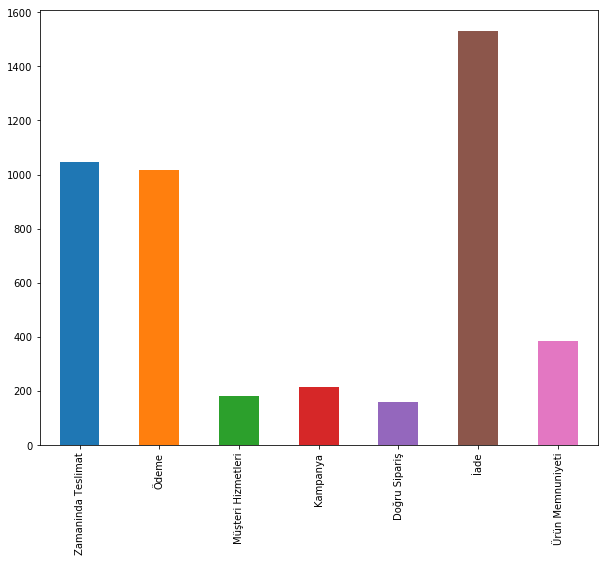

In [75]:
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

df_yemek_comments_labels.sum(axis=0).plot.bar()

# Multi-lable Text Classification Model with Single Output Layer

In [84]:
from numpy import loadtxt,array
from keras.models import Sequential
import seaborn as sn
from matplotlib import pyplot
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

In [122]:
X = []
sentences = list(df_yemek["Comment"])
for sen in sentences:
    X.append(sen)

y = df_yemek_comments_labels.values

In [123]:
len(y)

2477

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [88]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [119]:
'''
from gensim.models import KeyedVectors
from gensim import models

embeddings_dictionary = KeyedVectors.load_word2vec_format('trmodel', binary=True)

embedding_matrix = np.zeros((vocab_size, 400))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary[word]
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
'''       

"\nfrom gensim.models import KeyedVectors\nfrom gensim import models\n\nembeddings_dictionary = KeyedVectors.load_word2vec_format('trmodel', binary=True)\n\nembedding_matrix = np.zeros((vocab_size, 400))\nfor word, index in tokenizer.word_index.items():\n    embedding_vector = embeddings_dictionary[word]\n    if embedding_vector is not None:\n        embedding_matrix[index] = embedding_vector\n"

In [120]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(7, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [93]:
print(model.summary())


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          2006100   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
Total params: 2,124,251
Trainable params: 118,151
Non-trainable params: 2,006,100
_________________________________________________________________
None


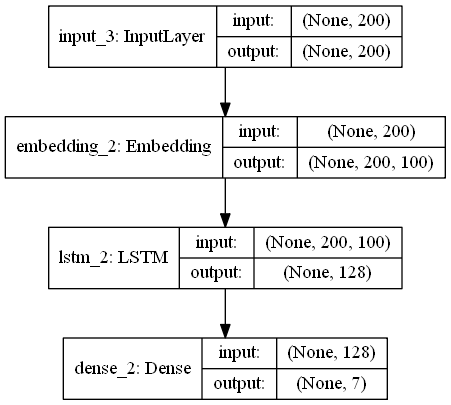

In [94]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [95]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 1584 samples, validate on 397 samples
Epoch 1/5
1584/1584 [==============================] - 8s 5ms/step - loss: 0.5788 - acc: 0.7554 - val_loss: 0.4600 - val_acc: 0.7794
Epoch 2/5
1584/1584 [==============================] - 7s 5ms/step - loss: 0.4709 - acc: 0.7713 - val_loss: 0.4544 - val_acc: 0.7794
Epoch 3/5
1584/1584 [==============================] - 9s 6ms/step - loss: 0.4664 - acc: 0.7713 - val_loss: 0.4517 - val_acc: 0.7794
Epoch 4/5
1584/1584 [==============================] - 10s 6ms/step - loss: 0.4655 - acc: 0.7713 - val_loss: 0.4518 - val_acc: 0.7794
Epoch 5/5
1584/1584 [==============================] - 9s 6ms/step - loss: 0.4661 - acc: 0.7713 - val_loss: 0.4554 - val_acc: 0.7794


In [96]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

496/496 [==============================] - 1s 2ms/step
Test Score: 0.47743904206060594
Test Accuracy: 0.7695853114128113


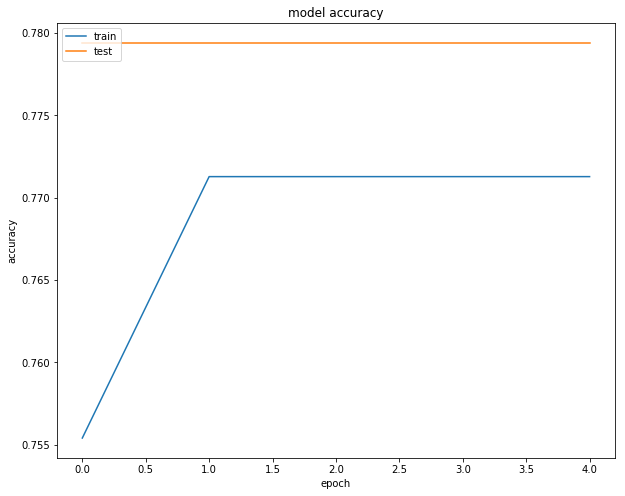

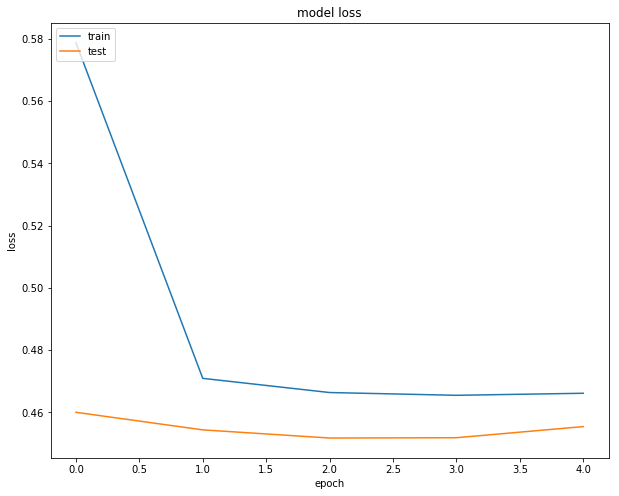

In [97]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Multi-lable Text Classification Model with Multiple Output Layers

In [ ]:
#"Zamaninda Teslimat","Ödeme","Müşteri Hizmetleri","Kampanya","Doğru Sipariş","İade","Ürün Memnuniyeti"

In [127]:
X = []
sentences = list(df_yemek["Comment"])
for sen in sentences:
    X.append(sen)

y = df_yemek[["Zamaninda Teslimat","Ödeme","Müşteri Hizmetleri","Kampanya","Doğru Sipariş","İade","Ürün Memnuniyeti"]]

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [129]:
# First output
y1_train = y_train[["Zamaninda Teslimat"]].values
y1_test =  y_test[["Zamaninda Teslimat"]].values

# Second output
y2_train = y_train[["Ödeme"]].values
y2_test =  y_test[["Ödeme"]].values

# Third output
y3_train = y_train[["Müşteri Hizmetleri"]].values
y3_test =  y_test[["Müşteri Hizmetleri"]].values

# Fourth output
y4_train = y_train[["Kampanya"]].values
y4_test =  y_test[["Kampanya"]].values

# Fifth output
y5_train = y_train[["Doğru Sipariş"]].values
y5_test =  y_test[["Doğru Sipariş"]].values

# Sixth output
y6_train = y_train[["İade"]].values
y6_test =  y_test[["İade"]].values

# Seventh output
y7_train = y_train[["Ürün Memnuniyeti"]].values
y7_test =  y_test[["Ürün Memnuniyeti"]].values

In [130]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [137]:
input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output6 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output7 = Dense(1, activation='sigmoid')(LSTM_Layer1)


model = Model(inputs=input_1, outputs=[output1, output2, output3, output4, output5, output6, output7])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [138]:
print(model.summary())


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 200, 100)     2006100     input_10[0][0]                   
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 128)          117248      embedding_9[0][0]                
__________________________________________________________________________________________________
dense_31 (Dense)                (None, 1)            129         lstm_8[0][0]                     
____________________________________________________________________________________________

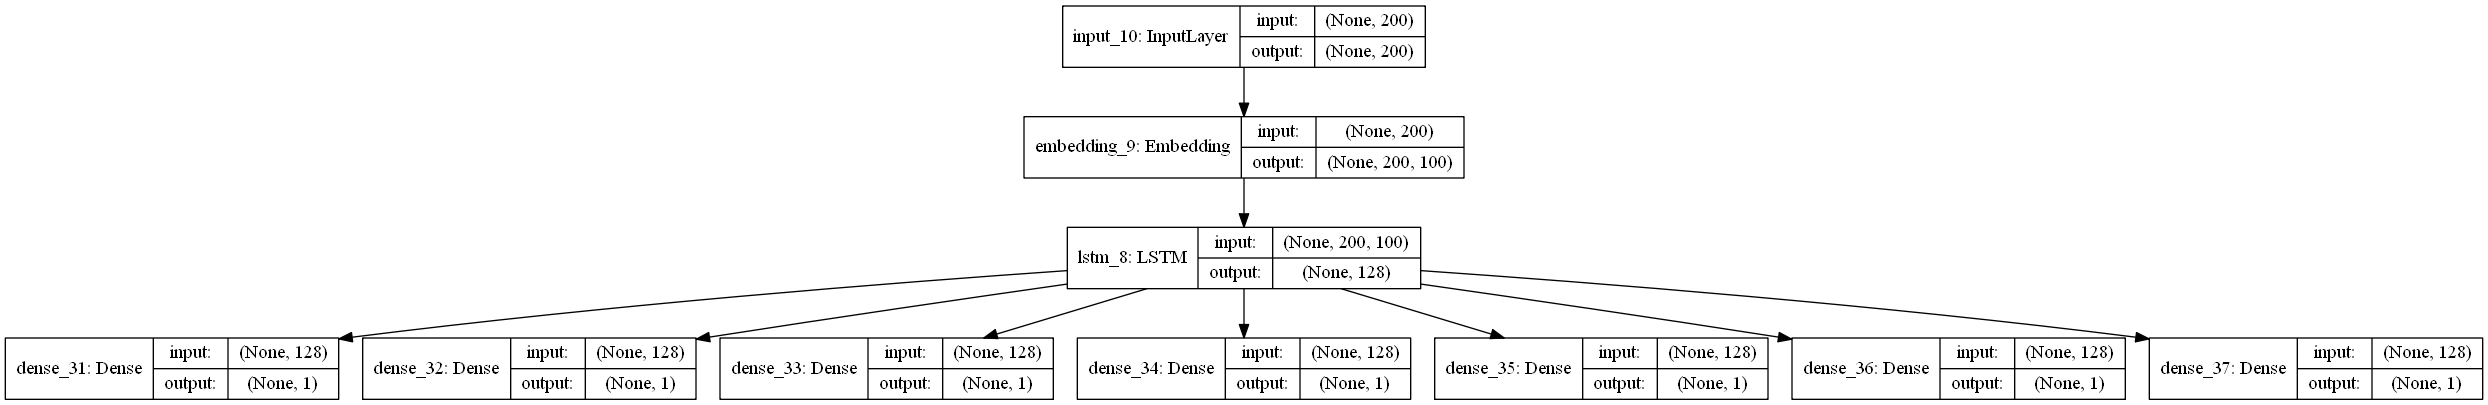

In [139]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4b.png', show_shapes=True, show_layer_names=True)

In [146]:
history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train, y7_train], batch_size=8192, epochs=5, verbose=1, validation_split=0.2)

Train on 1584 samples, validate on 397 samples
Epoch 1/5
1584/1584 [==============================] - 5s 3ms/step - loss: 4.7398 - dense_31_loss: 0.6926 - dense_32_loss: 0.6908 - dense_33_loss: 0.6630 - dense_34_loss: 0.6614 - dense_35_loss: 0.6609 - dense_36_loss: 0.6948 - dense_37_loss: 0.6764 - dense_31_acc: 0.5638 - dense_32_acc: 0.5814 - dense_33_acc: 0.9223 - dense_34_acc: 0.9141 - dense_35_acc: 0.9318 - dense_36_acc: 0.3744 - dense_37_acc: 0.8447 - val_loss: 4.6684 - val_dense_31_loss: 0.6918 - val_dense_32_loss: 0.6891 - val_dense_33_loss: 0.6404 - val_dense_34_loss: 0.6430 - val_dense_35_loss: 0.6443 - val_dense_36_loss: 0.6930 - val_dense_37_loss: 0.6669 - val_dense_31_acc: 0.6121 - val_dense_32_acc: 0.5945 - val_dense_33_acc: 0.9521 - val_dense_34_acc: 0.9144 - val_dense_35_acc: 0.9471 - val_dense_36_acc: 0.6020 - val_dense_37_acc: 0.8388
Epoch 2/5
1584/1584 [==============================] - 5s 3ms/step - loss: 4.6745 - dense_31_loss: 0.6924 - dense_32_loss: 0.6895 - dense_

In [147]:

score = model.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test, y6_test, y7_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

496/496 [==============================] - 1s 3ms/step
Test Score: 3.9905738830566406
Test Accuracy: 0.6850904226303101


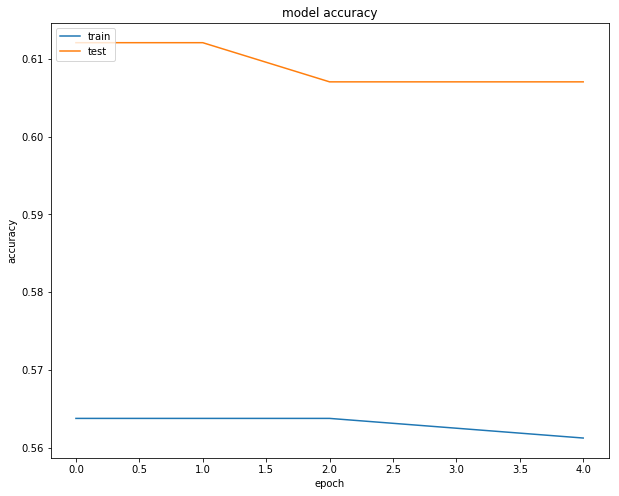

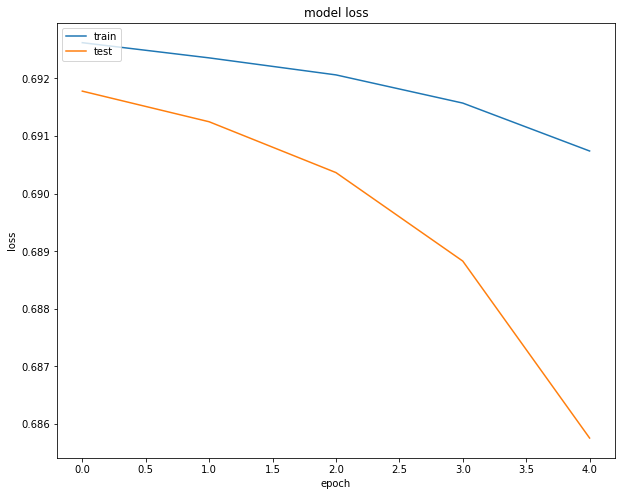

In [149]:
import matplotlib.pyplot as plt

plt.plot(history.history['dense_31_acc'])
plt.plot(history.history['val_dense_31_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_31_loss'])
plt.plot(history.history['val_dense_31_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# RAKE


In [36]:
#from rake_nltk import Metric,Rake

In [37]:
#rake_object = Rake(stopwords='turkce-stop-words')
#rake_object = Rake(ranking_metric=Metric.DEGREE_TO_FREQUENCY_RATIO)
#rake_object = Rake(ranking_metric=Metric.WORD_DEGREE)
#rake_object = Rake(ranking_metric=Metric.WORD_FREQUENCY)
#rake_object = Rake(min_length=1, max_length=2)


In [38]:
text = "Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear Diophantine equations, strict inequations, and nonstrict inequations are considered.Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generatingsets of solutions for all types of systems are given. These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types of systems and systems of mixed types."

In [39]:
#text1 =''
##for i in data_giyim:
#    text1 = text1+str(i)

In [40]:
#text1

In [41]:
#rake_object.extract_keywords_from_text(text1)

In [42]:
#rake_object.get_ranked_phrases()

In [43]:
#rake_object.get_ranked_phrases_with_scores()